# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 04.12.2021

Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.style.use('seaborn-dark')

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

32.66182233853414

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
#Взято из: https://pastebin.com/PmWH2swR

def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    X_ = np.concatenate((X, y.reshape(y.size, 1)), axis=1)
    X_ = pd.DataFrame(X_)

    result = np.zeros((X_.shape[0], 4))
    result = pd.DataFrame(result)

    for iter_ in range(num_runs):
        X_sample = X_.sample(frac=0.99, replace=True)
        y_sample = X_sample.iloc[:, -1]

        X_out_of_bag = X_.drop(X_sample.index, axis=0)
        y_out_of_bag = X_out_of_bag.iloc[:, -1]

        X_sample = X_sample.drop(columns=[X_sample.columns[-1]], axis=1)
        X_out_of_bag = X_out_of_bag.drop(columns=[X_out_of_bag.columns[-1]], axis=1)

        regressor.fit(X_sample, y_sample)
        y_pred = regressor.predict(X_out_of_bag)

        result.iloc[X_out_of_bag.index, 3] += (y_pred - y_out_of_bag.values)**2
        result.iloc[X_out_of_bag.index, 1] += y_pred
        result.iloc[X_out_of_bag.index, 2] += y_pred**2
        result.iloc[X_out_of_bag.index, 0] += 1

    valid_indexes = result.iloc[:, 0] > 0
    bias = (result.loc[valid_indexes, 1] / result.loc[valid_indexes, 0] - y) ** 2
    bias = np.mean(bias)
    variance = result.loc[valid_indexes, 2] / result.loc[valid_indexes, 0] - (result.loc[valid_indexes, 1] / result.loc[valid_indexes, 0]) ** 2
    variance = np.mean(variance)
    error = result.loc[valid_indexes, 3] / result.loc[valid_indexes, 0]
    error = np.mean(error)

    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

lr_bias, lr_variance, lr_error = compute_biase_variance(lr, X, y, num_runs=1000)
dt_bias, dt_variance, dt_error = compute_biase_variance(dt, X, y, num_runs=1000)
rf_bias, rf_variance, rf_error = compute_biase_variance(rf, X, y, num_runs=1000)

print("Linear Regression: bias ", lr_bias, ", variance ", lr_variance, ", error", lr_error)
print("Decision Tree: bias ", dt_bias, ", variance ", dt_variance, ", error", dt_error)
print("Random Forest: bias ", rf_bias, ", variance ", rf_variance, ", error", rf_error)

bag_lr = BaggingRegressor(lr)
bag_dt = BaggingRegressor(dt)
bag_rf = BaggingRegressor(rf)

lr_bias, lr_variance, lr_error = compute_biase_variance(bag_lr, X, y, num_runs=1000)
dt_bias, dt_variance, dt_error = compute_biase_variance(bag_dt, X, y, num_runs=1000)
rf_bias, rf_variance, rf_error = compute_biase_variance(bag_rf, X, y, num_runs=1000)

print("Bagging Linear Regression: bias ", lr_bias, ", variance ", lr_variance, ", error", lr_error)
print("Bagging Decision Tree: bias ", dt_bias, ", variance ", dt_variance, ", error", dt_error)
print("Bagging Random Forest: bias ", rf_bias, ", variance ", rf_variance, ", error", rf_error)

Linear Regression: bias  23.702636412191314 , variance  0.9292086272731654 , error 24.631845039464423
Decision Tree: bias  10.320933784226368 , variance  13.099929113636938 , error 23.42086289786331
Random Forest: bias  10.739693714180504 , variance  2.2540177054473407 , error 12.993711419627898
Bagging Linear Regression: bias  23.698785417558824 , variance  1.0311065060682523 , error 24.72989192362713
Bagging Decision Tree: bias  10.719806411170094 , variance  3.371641669774979 , error 14.091448080945119
Bagging Random Forest: bias  11.652146848440795 , variance  1.4225758596426181 , error 13.074722708083383


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__  Да, все результаты согласуются с тем, что было обсуждено на занятиях. Например, смещение больше всего у линейной регрессии и у неё же меньше всего разброс -- такое свойственно слабым семействам, к которым и относится линейная регрессия. Решающее дерево и случайный лес практически не отличаются в смещении, но разброс куда меньше у случайного леса. Большой разброс свойственнен сложным семействам, к которым относится решающее дерево. Как раз эту проблему решает случайный лес, поскольку он "притупляет" чувствительность решающих деревьев к изменениям в выборке (поскольку деревья известны своей лёгкой переобучаемостью). Из всех алгоритмов ошибка меньше всего у случайного леса -- это ожидаемо, поскольку сумма смещения и разброса у него меньшая из всех, а сам случайный лес является одним из самых сильных методов построения композиции.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ На занятиях обсуждалось то, что если базовые алгоритмы некоррелированы, то величина разброса уменьшается на длину композиции. Но если базовые алгоритмы коррелированы, то уменьшение разброса будет куда меньшим. Всё это выполняется в рамках эксперимента: например, разброс линейной регрессия совсем не уменьшился, а даже немного увеличился. Происходит это потому, что базовые алгоритмы у линейной регрессии сильно коррелированы, из-за чего эффекта от бэггинга совсем нет. Это контрастирует с тем, что показывают решающие деревья, поскольку для них разброс уменьшился значительно. Это произошло потому, что базовые алгоритмы решающего дерева коррелируют не так сильно, из-за чего бэггинг уменьшает разброс. Но эффект от бэггинга намного меньше у случайного леса, поскольку случайный лес сам по себе является бэггингом над решающими деревьями, хоть и с некоторыми отличиями от обычного бэггинга.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [37]:
#Взято из: https://pastebin.com/PtMbSJzc

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    perm = np.random.permutation(len(X))
    test_indices = perm[:num_test_objects]
    train_indices = perm[num_test_objects:]
    X_test = X[test_indices]
    y_test = y[test_indices]
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    for i in range(num_runs):
        indices = np.random.randint(0, len(X_train), len(X_train))
        X_j = X_train[indices]
        y_j = y_train[indices]
        y_pred = regressor.fit(
            X_j,
            y_j
        ).predict(X_test)

        x_ = np.arange(num_test_objects)
        y_ = y_pred

        plt.scatter(x_, y_, c = "#08F7FE")

    plt.title(title)
    plt.xlabel('num of test objects')
    plt.ylabel('Predicted values')

    plt.scatter(np.arange(num_test_objects), y_test, c = '#000000')

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

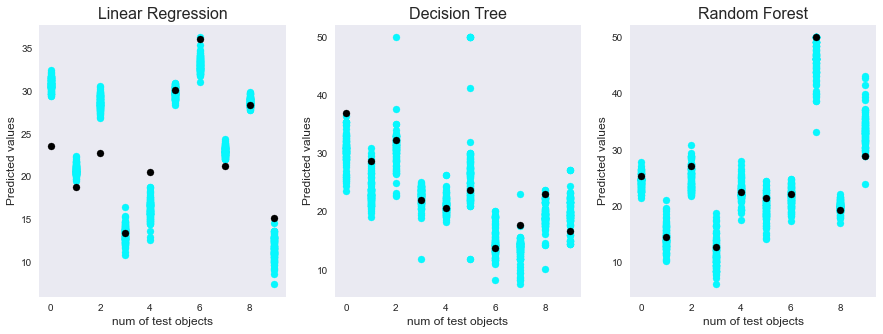

In [38]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

plt.subplot(1, 3, 1)
plot_predictions(lr, X, y, num_runs=100, num_test_objects=10, title="Linear Regression")
plt.subplot(1, 3, 2)
plot_predictions(dt, X, y, num_runs=100, num_test_objects=10, title="Decision Tree")
plt.subplot(1, 3, 3)
plot_predictions(rf, X, y, num_runs=100, num_test_objects=10, title="Random Forest")

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Для каждого графика бирюзовые точки характеризуют предсказание, в то время как чёрные -- реальный ответ. Исходя из этого, можно начинать проводить уже сравнения и анализ.

Смещение на графиках характеризуется тем, насколько "смещены" бирюзовые точки по отношению к чёрной.  Несложно заметить, что сильнее всего смещены значения на первом графике, графике с линейной регрессией. Это согласуется с результатами, полученными раннее -- действительно, сильное смещение, свойственное линейной регрессии, было получено в ходе вычислений в предыдущем задании. Смещение у решающего дерева и случайного леса же намного меньше, что также согласуется с данными прошлого задания, и они практически не отличаются друг друга в этом отношении.

Разброс же на графиках характеризуется тем, насколько бирюзовые точки "разбросаны" вдоль оси y. Сходу можно заметить, что на графике с линейной регрессии разброс очень слабый -- все бирюзовые точки "скучкованы" примерно в одном месте, что соотносится с результатом, полученным в предыдущем задании. Сильнее всего разброс заметен у решающего деревья -- очень многие значения бирюзовых точек были распределены вдоль оси y вдалеке от реального значения. На этом фоне выгодно смотрится случайный лес -- для него разброс получился намного меньший.

Всё это соотносится с результатами, полученными в предыдущем задании, и теоретическим материалом с занятий. 

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

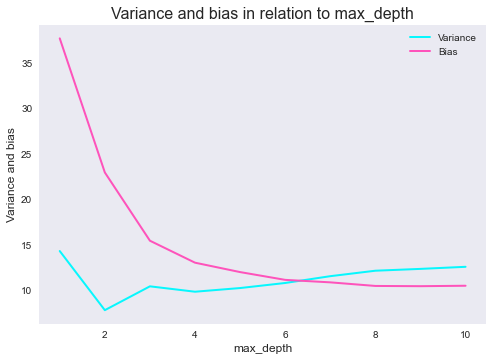

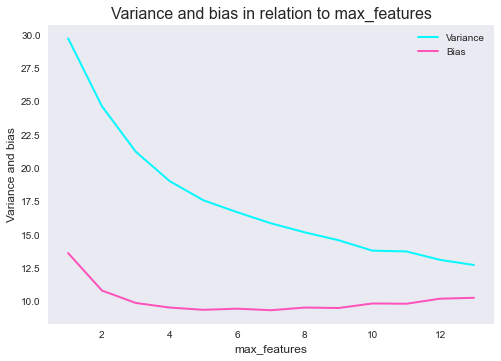

In [45]:
max_depth_variance = []
max_depth_bias = []
max_features_variance = []
max_features_bias = []

for max_depth in range(1,11):
    dt = DecisionTreeRegressor(max_depth = max_depth)
    bias, variance,_ = compute_biase_variance(dt, X, y, num_runs=1000)
    max_depth_bias.append(bias)
    max_depth_variance.append(variance)
    
for max_features in range(1, X.shape[1]+1):
    dt = DecisionTreeRegressor(max_features = max_features)
    bias, variance,_ = compute_biase_variance(dt, X, y, num_runs=1000)
    max_features_bias.append(bias)
    max_features_variance.append(variance)
    
plt.plot(range(1,11), max_depth_variance, color = "#08F7FE")
plt.plot(range(1,11), max_depth_bias, color = "#FE53BB")
plt.title("Variance and bias in relation to max_depth")
plt.xlabel("max_depth")
plt.ylabel("Variance and bias")
plt.legend(["Variance", "Bias"])
plt.show()

plt.plot(range(1, X.shape[1]+1), max_features_variance, color = "#08F7FE")
plt.plot(range(1, X.shape[1]+1), max_features_bias, color = "#FE53BB")
plt.title("Variance and bias in relation to max_features")
plt.xlabel("max_features")
plt.ylabel("Variance and bias")
plt.legend(["Variance", "Bias"])
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

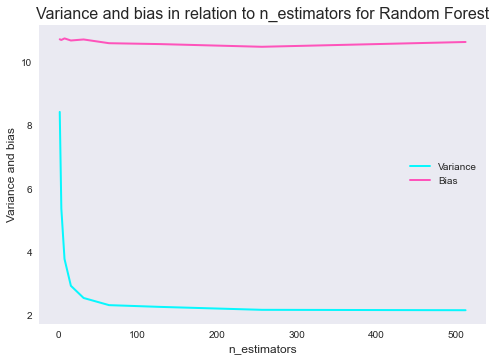

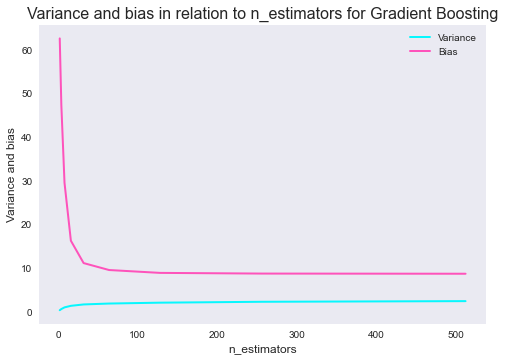

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

rf_variance = []
rf_bias = []
gb_variance = []
gb_bias = []

for n_estimators in 2**np.arange(1, 10):
    rf = RandomForestRegressor(n_estimators = n_estimators)
    bias, variance,_ = compute_biase_variance(rf, X, y, num_runs=1000)
    rf_bias.append(bias)
    rf_variance.append(variance)
    
for n_estimators in 2**np.arange(1, 10):
    gb = GradientBoostingRegressor(n_estimators = n_estimators)
    bias, variance,_ = compute_biase_variance(gb, X, y, num_runs=1000)
    gb_bias.append(bias)
    gb_variance.append(variance)    
    
plt.plot(2**np.arange(1, 10), rf_variance, color = "#08F7FE")
plt.plot(2**np.arange(1, 10), rf_bias, color = "#FE53BB")
plt.title("Variance and bias in relation to n_estimators for Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("Variance and bias")
plt.legend(["Variance", "Bias"])
plt.show()

plt.plot(2**np.arange(1, 10), gb_variance, color = "#08F7FE")
plt.plot(2**np.arange(1, 10), gb_bias, color = "#FE53BB")
plt.title("Variance and bias in relation to n_estimators for Gradient Boosting")
plt.xlabel("n_estimators")
plt.ylabel("Variance and bias")
plt.legend(["Variance", "Bias"])
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ На первом графике зависимости смещения и разброса от максимальной глубины заметно, что сильнее всего в начале снижается смещение, а потом оно выходит на плато, и что разбос сначала резко снижается, а потом начинает медленно расти вверх. Объясняется это особенностью решающих деревьев: поскольку дерево становится всё глубже и глубже, то смещение, очевидно будет падать, потому что целевая переменная будет предсказываться всё лучше и лучше, но при этом же приувеличении глубины дерева увеличивается вероятность его же переобучить -- именно поэтому после определённой отметки начинает расти разброс. Разброс характеризует "чувствительность" алгоритма, а чувствительность дерева как раз зависит от его глубины -- чем больше максимальная глубина, тем более чувствительно дерево к изменениям в выборке.

На втором графике показано, как и смещение, и разброс оба снижаются по мере того, как растёт количество признаков, по которым можно сделать перебор в поисках лучшего сплита, пока смещение не начинает немного расти. Объясняется это тем, что с увеличением признаков построение будет более однообразным, а потому разброс будет меньше, тк будет снижаться чувствительность алгоритма. Но при этом после определённого момента будет немного расти смещение, но рост довольно незначителен -- просто алгоритм может становиться несколько неоптимальным. 

На третьем графике видно, что смещение остаётся тем же (причём ненулевым), в то время как разброс резко снижается, пока не выходит на плато. Следует помнить, что это случайный лес -- бэггинг над деревьями, хоть и имеющий свои особенности. Особенность бэггинга в том, что он никак не уменьшает смещение, оно остаётся таким же, каким был в базовом алгоритме. Бэггинг как раз уменьшает разброс за счёт усреднения ответов -- именно это видно на графике.

На четвёртом графике видно, что сейчас наоборот -- падает смещение, в то время как разброс  совсем незначительно растёт. В этот раз используется бустинг, который целенаправленно понижает с каждой итерацией ошибку композиции, в отличие от бэггинга, который просто усреднял ответы многих деревьев. Именно за счёт этого уменьшается именно смещение алгоритма, но не его разброс, который наоборот может слегка увеличиться.

__Важное примечание!__ Для заданий 1 и 5 были использованы готовые решения по следующим ссылкам соответственно: https://pastebin.com/PmWH2swR и https://pastebin.com/PtMbSJzc